In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set (2 ways to do it)
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [9]:
month = latest_date[0][5:7]
month

'08'

In [10]:
query_date = dt.date(2011, 4, 8) - dt.timedelta(days=7)

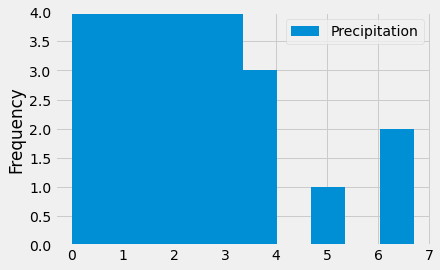

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year = int(latest_date[0][:4])
month = int(latest_date[0][5:7])
day = int(latest_date[0][8:10])

query_date = dt.date(year, month, day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>=query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data = []
for row in prcp_data:
    data.append(row)

prcp_df = pd.DataFrame(data, columns=['Date','Precipitation'])
prcp_df = prcp_df.set_index('Date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by=['Date'])


prcp_df = prcp_df.fillna(0)



# Use Pandas Plotting with Matplotlib to plot the data

x_ticks = ['2016-08-23']
prcp_df.plot(kind='hist', ylim = [0,4])
plt.xticks()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Measurement.station).group_by(Measurement.station).all()
num_of_st = len(stations)
num_of_st

9

In [35]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

#Create Pandas DataFrame of query
station_df = pd.DataFrame(columns = ['Station', 'Station Count'])
for row in station_count:
    station_df = station_df.append({'Station':row[0],'Station Count':row[1]}, ignore_index=True)

#Print Dataframe
print(f'The station counts are as follow:')
print(station_df)

#Print most active station
most_active_station = station_df.iloc[0,0]
print(f'The most active station is: {most_active_station}')

The station counts are as follow:
       Station Station Count
0  USC00519281          2772
1  USC00519397          2724
2  USC00513117          2709
3  USC00519523          2669
4  USC00516128          2612
5  USC00514830          2202
6  USC00511918          1979
7  USC00517948          1372
8  USC00518838           511
The most active station is: USC00519281


In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#Query for station, min temp, max temp, and avg temp
sel = [Measurement.station, 
        func.min(Measurement.tobs), 
        func.max(Measurement.tobs), 
        func.avg(Measurement.tobs)]

#Pull values where station is most active station    
active_station_query = session.query(*sel).\
    filter(Measurement.station == most_active_station).\
    group_by(Measurement.station).all()

#Print results in this order: [station, min temp, max temp, avg temp]
active_station_query

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

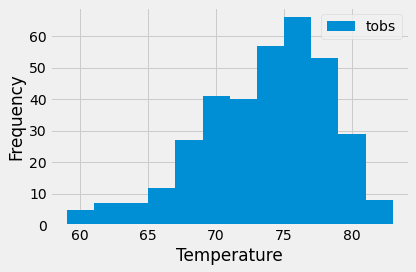

In [94]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Define what columns you need
sel2= [Measurement.station,
       Measurement.tobs]

#Query for 12 months of most active station
query = session.query(*sel2).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date>=query_date).all()
    #group_by(Measurement.tobs).all()

#Place query into Pandas DF
station_temp_df = pd.DataFrame(columns = ['tobs','frequency'])

for row in query:
    station_temp_df = station_temp_df.append({'tobs':row[0], 'frequency':row[1]}, ignore_index = True)

station_temp_df = station_temp_df.set_index('tobs')

#Plot histogram
station_temp_df.hist(bins=12)
plt.title("")
plt.legend(['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



# Close session

In [17]:
# Close Session
session.close()